# Solve the robotic manipulator problem with DAEs solvers 

## Mathematical modelling

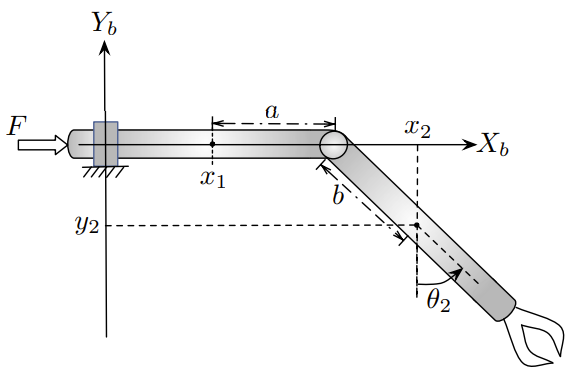

In [15]:
from IPython.display import Image
Image(filename="img/robot.png")

Let us consider the robotic manipulator represented in figure above and constituted by a rigid segment moving horizontally (body 1) to which a second rigid segment is articulated. The second segment could perform a rotation motion (body 2). The motion of the system is due to the application of the force $F$ applied horizontally on the first segment and the torque of rotation $T$ applied on the second segment. The inertial basis and the different coordinates are indicated in the figure. 

This system is subjected to two type of constraints 

- Path constraints :
 $$y_1 = 0$$ 
 $$\theta_1 = 0$$
- Link constraints :
 $$x_2 - b \sin \theta_2 - x_1 - a = 0$$
 $$y_2 + b \cos \theta_2 = 0$$

Using the Lagrange multiplier method, the following equations are obtained : 

\begin{align*}
        m_1 \ddot{x}_1 &= F - \lambda_3 \\
        I_2 \ddot{\theta}_2 &= -\lambda_3 b \cos \theta_2 - \lambda_4 b \sin \theta_2 + T \\ 
        m_1\ddot{y}_1 &= -m_1 g + \lambda_1 \\
        I_1 \ddot{\theta}_1 &= \lambda_2 \\
        m_2 \ddot{x}_2 &= \lambda_3 \\
        m_2 \ddot{y}_2 &= -m_2 g + \lambda_4
    \end{align*}

Using the motion constraints, we can determine $\lambda_1 = m_1 \; g$ and $\lambda_2 = 0$ from equations 3 and 4.

\begin{align*}
\left\{ 
\begin{aligned}
    m_1 \ddot{x}_1 &= F - \lambda_3 \\
    I_2 \ddot{\theta}_2 &= -\lambda_3 b \cos \theta_2 - \lambda_4 b \sin \theta_2 + T \\ 
    m_2 \ddot{x}_2 &= \lambda_3 \\
    m_2 \ddot{y}_2 &= -m_2 g + \lambda_4\\
    0 &= x_2 - b \sin \theta_2 - x_1 - a \\
    0 &= y_2 + b \cos \theta_2
\end{aligned}
\right.
\end{align*}
    
This is an index 3 DAE system since 3 successive derivations of the constraint(s) must be applied to obtain an ODE. Thus, deriving twice the constraint and reduce the order of the derivative gives us the following index 1 DAE system:

\begin{align*}
\left\{
\begin{aligned}
    \dot{x}_1 &= u \\
    m_1 \dot{u} &= F - \lambda_3 \\
    \dot{x}_2 &= v \\
    m_2 \dot{v} &= \lambda_3 \\
    \dot{y}_2 &= w \\
    m_2 \dot{w} &= -m_2 g + \lambda_4\\
    \dot{\theta}_2 &= \alpha \\
    I_2 \dot{\alpha} &= -\lambda_3 b \cos \theta_2 - \lambda_4 b \sin \theta_2 + T \\ 
    0 &= \dot{v} - b \dot{\alpha} \cos \theta_2 + b \alpha^2 \sin \theta_2 - \dot{u} \\
    0 &= \dot{w} - b \dot{\alpha} \sin \theta_2 - b \alpha^2 \cos \theta_2
\end{aligned}
\right.
\end{align*}

We replace the values of $\dot{u}, \dot{v}, \dot{w}$ and $\dot{\alpha}$ in the last two equations to obtain constraints that depend on the variables $\lambda_3$ and $\lambda_4$. 

### ODE system

To obtain an ODE system, one normally has to derive the constraints of the index 1 DAE system. By deriving the last two equations, one obtains very complex expressions. The general dynamic of an articulated mechanical system is therefore used:

$$ M(q)\ddot{q} + f(q, \dot{q}) + g(q) = G(q)u$$

where $q = \begin{bmatrix}
    x_1 \\ \theta_2
    \end{bmatrix}$ Once the general dynamic model has been derived, the last remaining step is to write the system state model :

\begin{align*}
        \dot{q} &= v \\
        \dot{v} &= M^{-1}(q)[-f(q, v) - g(q) + G(q)u]
    \end{align*}

With our problem, we have : 

- $q = \begin{bmatrix} x_1 \\ \theta_2 \end{bmatrix}$
- $M(q) = \begin{bmatrix} m_1 + m_2 & m_2 b \cos \theta_2 \\ m_2 b \cos \theta_2 & I_2 + m_2 b^2 \end{bmatrix}$
- $C(q,\dot{q}) = \begin{bmatrix} 0 & -m_2 b \dot{\theta}_2 \sin \theta_2 \\ 0 & 0 \end{bmatrix}$ => $f(q,\dot{q}) = C(q,\dot{q})\dot{q}$
- $g(q) = \begin{bmatrix} 0 \\ b m_2 g \sin \theta_2 \end{bmatrix}$
- $G(q)u = \begin{bmatrix} F \\ T \end{bmatrix}$

## Solving those systems with DAEs solvers

In [3]:
# import solvers
from solvers.bdfSolver import BDFModified
from solvers.Final import SABMScipy
from solvers.radau import RadauModified
from solvers.rosScipyFinal import Rosenbrock

In [4]:
# import other useful modules
from time import time
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import numpy as np

Declare the constants of the robot manipulator problem:

In [5]:
m1 = 1
m2 = 1
g = 9.81
F = lambda t : 0 # force and torque applied can depend on time
T = lambda t : 0
I1 = 1
I2 = 1
a = 1 
b = 1

tspan = [0, 10]

Find the initial condition :

In [6]:
theta = np.pi/3
x1 = 0.5
def equations(z):
    return np.array([ z[0]/m2 - b*((-z[0]*b*np.cos(theta) - z[1]*b*np.sin(theta) + T(0))/I2)*np.cos(theta) - (F(0) - z[0])/m1,
                      (-m2*g + z[1])/m2 - b*(-z[0]*b*np.cos(theta) - z[1]*b*np.sin(theta) + T(0))/I2 * np.sin(theta)])

z = fsolve(equations, [0, 0])
lamb3, lamb4 = z
y0 = [x1, 0, x1+a+b*np.sin(theta), 0, -b*np.cos(theta), 0, theta, 0, lamb3, lamb4]

Create the function describing the DAEs systems such that $M \dot{y} = f(t,y)$:

In [7]:
def f_robot_index3(t, y):
    [x1, u, x2, v, y2, w, theta, alpha, lambda3, lambda4] = y

    return np.array([u,
                     (F(t) - lambda3)/m1,
                     v,
                     lambda3/m2,
                     w,
                     (-m2*g + lambda4)/m2,
                     alpha,
                     (-lambda3*b*np.cos(theta) - lambda4*b*np.sin(theta) + T(t))/I2,
                     x2 - b*np.sin(theta) - x1 - a,
                     y2 + b*np.cos(theta)])

def f_robot_index1(t, y):
    [x1, u, x2, v, y2, w, theta, alpha, lambda3, lambda4] = y

    return np.array([u, 
                     (F(t) - lambda3)/m1,
                     v,
                     lambda3/m2,
                     w,
                     (-m2*g + lambda4)/m2,
                     alpha,
                     (-lambda3*b*np.cos(theta) - lambda4*b*np.sin(theta) + T(t))/I2,
                     lambda3/m2 - b*((-lambda3*b*np.cos(theta) - lambda4*b*np.sin(theta) + T(t))/I2)*np.cos(theta) + b*np.sin(theta)*alpha**2 - (F(t) - lambda3)/m1,
                     (-m2*g + lambda4)/m2 - b*((-lambda3*b*np.cos(theta) - lambda4*b*np.sin(theta) + T(t))/I2)*np.sin(theta) - b*np.cos(theta)*alpha**2])

# mass matrix
M = np.eye(10)
M[-1, -1] = 0
M[-2, -2] = 0 

# functions of the rhs linked to the derivatives, it's the rhs of the ODE part of the DAE system
def fun(t, y, x):
    [x1, u, x2, v, y2, w, theta, alpha] = y
    [lambda3, lambda4] = x

    return np.array([u, 
                     (F(t) - lambda3)/m1,
                     v,
                     lambda3/m2,
                     w,
                     (-m2*g + lambda4)/m2,
                     alpha,
                     (-lambda3*b*np.cos(theta) - lambda4*b*np.sin(theta) + T(t))/I2])

# algebraic constraints
def gun(t, y, x):
    [x1, u, x2, v, y2, w, theta, alpha] = y
    [lambda3, lambda4] = x
    
    return np.array([lambda3/m2 - b*((-lambda3*b*np.cos(theta) - lambda4*b*np.sin(theta) + T(t))/I2)*np.cos(theta) + b*np.sin(theta)*alpha**2 - (F(t) - lambda3)/m1,
                     (-m2*g + lambda4)/m2 - b*((-lambda3*b*np.cos(theta) - lambda4*b*np.sin(theta) + T(t))/I2)*np.sin(theta) - b*np.cos(theta)*alpha**2])
    

Parameters of the DAEs solvers similar to those scipy solve_ivp:

In [8]:
kwargsBDF = {
    'fun': f_robot_index1,
    't_span': tspan,
    'y0': y0,
    'mass': M,
    'method': BDFModified,
    'rtol': 1e-3,
    'atol': 1e-3,
    'first_step': 1e-8,
}


kwargsRadau = {
    'fun': f_robot_index3,
    't_span': tspan,
    'y0': y0,
    'mass': M,
    'method': RadauModified,
    'rtol': 1e-3,
    'atol': 1e-3,
    'dense_output': False
}

kwargsSEABM = {
    'fun': fun,
    't_span': tspan,
    'y0': y0,
    'method': SABMScipy,
    'gun': gun,
    'num_diff': 8,
    'order': 2,
    'atol': 1e-3,
    'rtol': 1e-3,
    'mode': 'Implicit'
}

Solve the DAEs:

In [9]:
kwargs = kwargsRadau

before = time()
sol = solve_ivp(**kwargs)
print(f'Success: {sol.success}')
print(f'Temps de calcul : {time()-before}')
t = sol.t

x1 = sol.y[0,:]
x2 = sol.y[2,:]
y2 = sol.y[4,:]
theta = sol.y[6,:]

Success: True
Temps de calcul : 0.2397618293762207


Solve the ODEs for the reference solution:

In [10]:
def solve_ODE():
    def ode(t, y):
        
        x1 = y[0]
        theta = y[1]
        u = y[2]
        v = y[3]
        
        M = np.array([[m1+m2, m2*b*np.cos(theta)],
                      [m2*b*np.cos(theta), I2 + m2*b**2]])
        C = np.array([[0, -m2*b*v*np.sin(theta)],
                      [0,0]])
        g_q = np.array([[0],
                        [b*m2*g*np.sin(theta)]])
        G = np.array([[F(t)], 
                      [T(t)]])
        
        q_dot = np.array([[u],[v]])
        v_dot = np.linalg.inv(M) @ (-C @ q_dot - g_q + G)

        return np.array([q_dot[0,0], q_dot[1,0], v_dot[0,0], v_dot[1,0]])

    y0 = np.array([0.5, np.pi/3, 0, 0])
    sol_ODE = solve_ivp(fun=ode, t_span=[tspan[0], sol.t[-1]], y0=y0, rtol=1e-12,
                        atol=1e-12, max_step=tspan[-1]/10, method='DOP853', t_eval=sol.t)
    x1 = sol_ODE.y[0,:]
    theta = sol_ODE.y[1, :]
    x2 = b*np.sin(theta) + x1 + a
    y2 = -b*np.cos(theta)
    return sol_ODE.t, x1, x2, y2, theta

t_ODE,x1_ODE,x2_ODE,y2_ODE, theta_ODE = solve_ODE()

Plot the $x_1$, $x_2$, $y_2$ and $\theta_2$ coordinates:

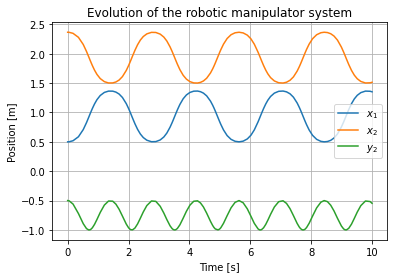

In [11]:
plt.figure()
plt.plot(t, x1, label="$x_1$")
plt.plot(t, x2, label="$x_2$")
plt.plot(t, y2, label="$y_2$")
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.title("Evolution of the robotic manipulator system")
plt.grid()
plt.legend()
plt.show()

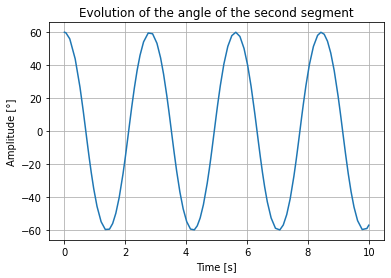

In [12]:
plt.figure()
plt.plot(t, theta*360/(2*np.pi), label=r"$\theta_2$")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [°]")
plt.title("Evolution of the angle of the second segment")
plt.grid()
plt.show()

Plot of the error in comparaison with the ODE solution:

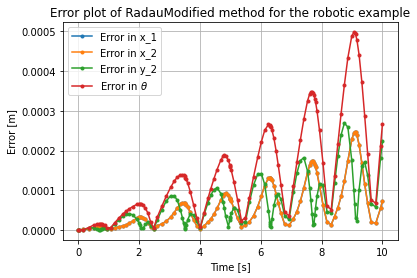

In [14]:
plt.figure()
plt.plot(sol.t, abs(x1 - x1_ODE), ".-", label='Error in x_1')
plt.plot(sol.t, abs(x2 - x2_ODE), ".-", label='Error in x_2')
plt.plot(sol.t, abs(y2 - y2_ODE), ".-", label='Error in y_2')
plt.plot(sol.t, abs(theta - theta_ODE), ".-", label=r'Error in $\theta$')
plt.plot()
plt.title(
    f'Error plot of {kwargs["method"].__name__} method for the robotic example')
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.grid()
plt.legend()
plt.show()